In [23]:
from pathlib import Path
import pickle as pkl
from glob import glob
import os
import sys; sys.path.insert(0, "..")
from typing import Sequence

from dotenv import load_dotenv
from matplotlib.image import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from plot_keras_history import show_history, plot_history

import seaborn as sns
from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout 
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

from src.constants import IMG_SQUARE_SIDE, LABELS_LIST
# print("Number of GPUs available: ", len(tf.config.list_physical_devices("GPU")))

In [ ]:
load_dotenv()
IMG_FOLDER = Path(os.getenv("DATASET_FOLDER"))

## Préparation du dataset

In [5]:
def get_image_label_from_filename(
    img_filename: str,
    possible_labels: Sequence[str] | None = None,
    label_not_found_value: str = "unknown",
) -> str:
    """Extract the label from the name of the image file."""
    if possible_labels is None:
        possible_labels = LABELS_LIST
    for label in possible_labels :
        if label in img_filename:
            return label
    return label_not_found_value

In [6]:
def create_data_from_img_files(path: str = IMG_FOLDER) -> pd.DataFrame:
    """Create a DataFrame containing all the paths to the images as well
    as the labels of these images.
    """
    images_list = glob(f"{path}*/*.jp*")  # in case some files are not jpg or jpeg files
    df_out = pd.DataFrame(data={"image_path": images_list})
    df_out["label_name"] = df_out["image_path"].apply(get_image_label_from_filename)
    return df_out

img_df = create_data_from_img_files()

In [7]:
le = preprocessing.LabelEncoder()
img_df["label"] = le.fit_transform(img_df["label_name"])

In [8]:
# Vérification du nombre d'images dans chaque classe
img_df.groupby("label").count()

,image_path,label_name
label,,
0,300,300
1,215,215
2,253,253
3,357,357


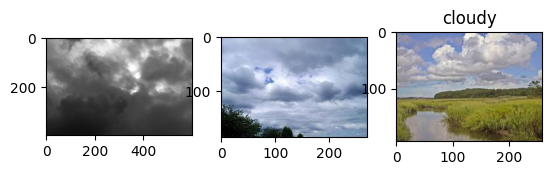

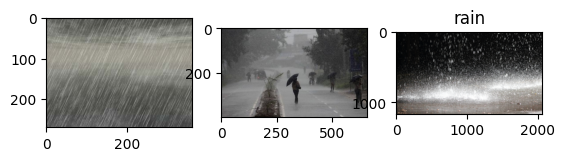

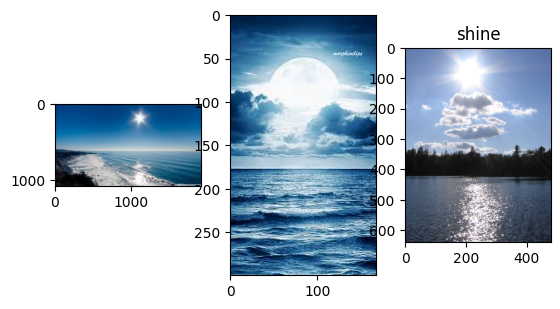

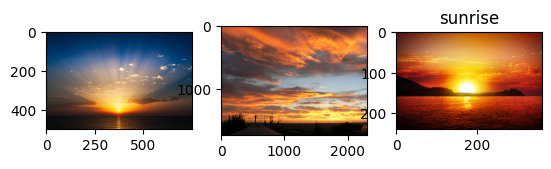

In [9]:
# Visualisation
for label_name in LABELS_LIST:
    img_path_list = img_df[img_df["label_name"]==label_name].reset_index().loc[0:2, "image_path"]
    for i in range(3):
        image = imread(img_path_list[i])
        plt.subplot(131 + i)
        plt.imshow(image)
    plt.title(label_name)
    plt.show()

### Création du modèle pré-entraîné

In [10]:
def create_model():
    """Create a model from the VGG16 model, adding a task head for image
    classification.
    """
    # Récupération du modèle pré-entraîné
    backbone = VGG16(
        include_top=False,
        weights="imagenet",
        input_shape=(IMG_SQUARE_SIDE, IMG_SQUARE_SIDE, 3),
    )

    # Gel des couches du modèle pré-entraîné
    for layer in backbone.layers:
        layer.trainable = False

    # Complétion du modèle avec une tête de classification
    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        Dense(256, activation="relu"),
        Dropout(0.5),
        Dense(4, activation="softmax"),
        ])

    # Compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model

## Préparation des images et des labels

In [11]:
def load_and_preprocess_images_from_img_path(
    image_path: str,
    target_square_size: int = IMG_SQUARE_SIDE,
) -> np.array:
    """Extract features from an image given its path."""
    img_array = img_to_array(
        load_img(
            image_path,
            target_size=(target_square_size, target_square_size),
        )
    )
    img_array = preprocess_input(img_array)
    return img_array

In [12]:
X = np.array(
    img_df["image_path"].apply(load_and_preprocess_images_from_img_path).to_list()
)
y = to_categorical(img_df["label"])

In [13]:
X[0][:, :, 0]

array([[ 22.060997,  28.060997,  30.060997, ...,  57.060997,  51.060997,
         42.060997],
       [ 23.060997,  28.060997,  30.060997, ...,  51.060997,  44.060997,
         35.060997],
       [ 25.060997,  28.060997,  31.060997, ...,  42.060997,  33.060997,
         28.060997],
       ...,
       [-79.939   , -79.939   , -79.939   , ..., -48.939003, -47.939003,
        -48.939003],
       [-80.939   , -80.939   , -80.939   , ..., -49.939003, -48.939003,
        -48.939003],
       [-81.939   , -81.939   , -81.939   , ..., -50.939003, -50.939003,
        -49.939003]], shape=(224, 224), dtype=float32)

In [14]:
X_macro_train, X_test, y_macro_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=0
)
X_train, X_val, y_train, y_val = train_test_split(
    X_macro_train, y_macro_train, stratify=y_macro_train, test_size=0.2, random_state=0
)

### Entraînement du modèle

In [ ]:
model_save_path = Path("../saved_objects/model_best_weights.h5")
checkpoint = ModelCheckpoint(
    model_save_path,
    monitor='val_loss',
    verbose=True,
    save_best_only=True,
    mode='min',
)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=True, patience=5)
callbacks = [checkpoint, es]

In [16]:
with tf.device("/cpu:0"): 
    model = create_model()
    history = model.fit(
        X_train,
        y_train,
        epochs=10,
        batch_size=64,
        callbacks=callbacks,
        validation_data=(X_val, y_val),
        verbose=True,
    )

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3497 - loss: 3.6553
Epoch 1: val_loss improved from None to 0.54401, saving model to ../saved_objects/model_best_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 129s 11s/step - accuracy: 0.4764 - loss: 2.6719 - val_accuracy: 0.8444 - val_loss: 0.5440
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7686 - loss: 0.9095
Epoch 2: val_loss improved from 0.54401 to 0.21826, saving model to ../saved_objects/model_best_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 110s 9s/step - accuracy: 0.8250 - loss: 0.6393 - val_accuracy: 0.9167 - val_loss: 0.2183
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8610 - loss: 0.3859
Epoch 3: val_loss did not improve from 0.21826
12/12 ━━━━━━━━━━━━━━━━━━━━ 113s 10s/step - accuracy: 0.8917 - loss: 0.3339 - val_accuracy: 0.9167 - val_loss: 0.2519
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9320 - loss: 0.1950
Epoch 4: val_loss improved from 0.21826 to 0.20382, saving model to ../saved_objects/model_best_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 114s 10s/step - accuracy: 0.9319 - loss: 0.1963 - val_accuracy: 0.9278 - val_loss: 0.2038
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9393 - loss: 0.1869
Epoch 5: val_loss did not improve from 0.20382
12/12 ━━━━━━━━━━━━━━━━━━━━ 122s 10s/step - accuracy: 0.9403 - loss: 0.1929 - val_accuracy: 0.9278 - val_loss: 0.2081
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9532 - loss: 0.1587 
Epoch 6: val_loss did not improve from 0.20382
12/12 ━━━━━━━━━━━━━━━━━━━━ 133s 11s/step - accuracy: 0.9514 - loss: 0.1544 - val_accuracy: 0.9278 - val_loss: 0.2061
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9490 - loss: 0.1319
Epoch 7: val_loss improved from 0.20382 to 0.18069, saving model to ../saved_objects/model_best_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 121s 10s/step - accuracy: 0.9556 - loss: 0.1197 - val_accuracy: 0.9278 - val_loss: 0.1807
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9629 - loss: 0.1347
Epoch 8: val_loss did not improve from 0.18069
12/12 ━━━━━━━━━━━━━━━━━━━━ 118s 10s/step - accuracy: 0.9653 - loss: 0.1138 - val_accuracy: 0.9222 - val_loss: 0.1939
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9832 - loss: 0.0692
Epoch 9: val_loss improved from 0.18069 to 0.17356, saving model to ../saved_objects/model_best_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 116s 10s/step - accuracy: 0.9819 - loss: 0.0712 - val_accuracy: 0.9333 - val_loss: 0.1736
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9775 - loss: 0.0598
Epoch 10: val_loss improved from 0.17356 to 0.15627, saving model to ../saved_objects/model_best_weights.h5


12/12 ━━━━━━━━━━━━━━━━━━━━ 110s 9s/step - accuracy: 0.9792 - loss: 0.0670 - val_accuracy: 0.9333 - val_loss: 0.1563


### Analyse des résultats

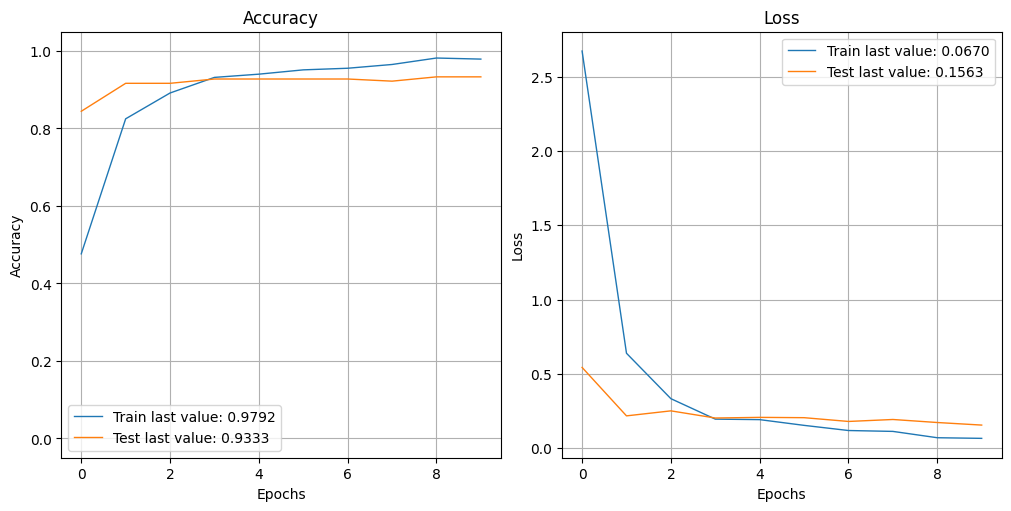

In [17]:
show_history(history)
plot_history(history, path="standard.png")
plt.close()

6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step


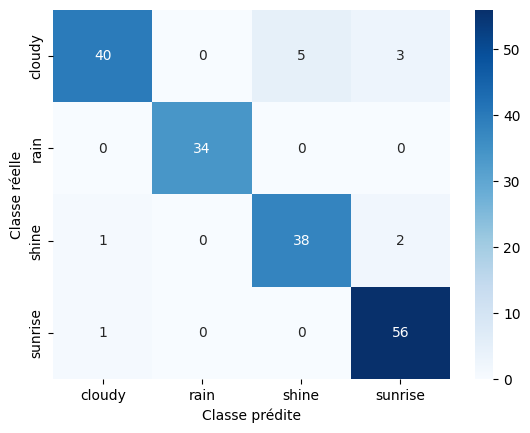

In [18]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model.predict(X_val), axis=1)
conf_mat = metrics.confusion_matrix(
    y_true=y_val_num,
    y_pred=y_val_pred,
)
sns.heatmap(
    data=conf_mat,
    annot=True,
    cmap="Blues",
    fmt="g",
    xticklabels=LABELS_LIST,
    yticklabels=LABELS_LIST,
)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.show()

In [19]:
print(metrics.classification_report(y_true=y_val_num, y_pred=y_val_pred))

              precision    recall  f1-score   support

           0       0.95      0.83      0.89        48
           1       1.00      1.00      1.00        34
           2       0.88      0.93      0.90        41
           3       0.92      0.98      0.95        57

    accuracy                           0.93       180
   macro avg       0.94      0.94      0.94       180
weighted avg       0.93      0.93      0.93       180



In [20]:
# Objet model actuel
loss, accuracy = model.evaluate(X_test, y_test, verbose=True)
print("Test Accuracy: {:.4f}".format(accuracy))

8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.9333 - loss: 0.1309
Test Accuracy: 0.9333


In [21]:
# Poids sauvegardés
model.load_weights(model_save_path)

loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9333


Préparation de la suite

In [ ]:
with open(Path("../saved_objects/img_df.pkl"), "wb") as handle:
    pkl.dump(img_df, handle)
with open(Path("../saved_objects/standard_model.pkl"), "wb") as handle:
    pkl.dump(model, handle)
with open(Path("../saved_objects/X_test.pkl"), "wb") as handle:
    pkl.dump(X_test, handle)